## Imports


In [3]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision import datasets, transforms
from torch.utils.data import random_split

import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim

import os
import time

from sklearn.metrics import precision_score, recall_score, f1_score

import pandas as pd
import csv

## Setup

<font size="6">Number of Epochs:</font> <br>
<font size="5">Variable: <font color="cyan">num_epochs</font></font>  <br>
<font color="orange">Description: </font> 
 This represents the total number of passes through the entire training dataset. <br>
 This value dictates how many times the network will see the entire dataset.

<font size="6">Learning Rate:</font> <br>
<font size="5">Variable: <font color="cyan">learning_rate</font></font>  <br>
<font color="orange">Description: </font> <br>
This controls the step size at each iteration while moving toward a minimum of a loss function. <br>
This parameter affects how quickly or slowly a neural network model learns.

<font size="6">Batch Size: </font> <br>
<font size="5">Variable: <font color="cyan">batch_size</font></font>  <br>
<font color="orange">Description: </font> <br>
This determines the number of samples that will be propagated through the network at once.

<font size="6">Optimizer: </font> <br>
<font size="5">Variable: <font color="cyan">optimizer</font></font>  <br>
<font color="orange">Description: </font> <br>
This is the algorithm used to update the weights of the network.

<font size="6">Loss Function: </font> <br>
<font size="5">Variable: <font color="cyan">loss_type</font></font>  <br>
<font color="orange">Description: </font> <br>
This measures the difference between the output of the neural network and the actual target values.

<font size="6">Input Channels: </font> <br>
<font size="5">Variable: <font color="cyan">input_channels</font></font>  <br>
<font color="orange">Description: </font> <br>
In the SimpleCNN class, this determines the number of channels in the input images that the network is designed to process. 

<font size="6">Convolutional Filters: </font> <br>
<font size="5">Variable: <font color="cyan">conv_filters</font></font>  <br>
<font color="orange">Description: </font> <br>
In the SimpleCNN class, this represents the number of output channels in the convolutional layers.

<font size="6">Kernel Size: </font> <br>
<font size="5">Variable: <font color="cyan">kernel_size</font></font>  <br>
<font color="orange">Description: </font> <br>
In the SimpleCNN class, this specifies the size of the window that will slide over the input data.

<font size="6">Fully Connected (FC) Neurons: </font> <br>
<font size="5">Variable: <font color="cyan">fc_neurons</font></font>  <br>
<font color="orange">Description: </font> <br>
In the SimpleCNN class, this determines the number of neurons in the fully connected layers.

<font size="6">Output Classes: </font> <br>
<font size="5">Variable: <font color="cyan">output_classes</font></font>  <br>
<font color="orange">Description: </font> <br>
 In the SimpleCNN class, this represents the number of different classes the model can predict. <br>
 For MNIST, this is set to 10, corresponding to the digits 0 through 9.

<font size="8">Set variables</font> <br>
<font size="6">Starting conditions</font> <br>

<font size="6">[<font color="orange">Miscellaneous</font>]</font> <br>
<font color="cyan">Default values</font> <br>
num_epochs = 1 <br>
learning_rate = 0.001 <br>
batch_size = 64 <br>
optimizer_type = 'Adam' <br>
loss_type = nn.CrossEntropyLoss() <br>

<font size="6">[<font color="orange">Miscellaneous</font>]</font> <br>
<font color="cyan">Better values</font> <br>
num_epochs = 15 <br>
learning_rate = 0.001 <br>
batch_size = 64 <br>
optimizer_type = 'Adam' <br>
loss_type = nn.CrossEntropyLoss() <br>

In [4]:
num_epochs = 1
learning_rate = 0.001
batch_size = 64
optimizer_type = 'Adam'
loss_type = nn.CrossEntropyLoss()

<font size="6">[<font color="olive">SimpleCNN arguments</font>]</font> <br>
<font color="cyan">Default values</font> <br>
input_channels=1 <br>
conv_filters=16 <br>
kernel_size=3 <br>
fc_neurons=64 <br>
output_classes=10 

<font size="6">[<font color="olive">SimpleCNN arguments</font>]</font> <br>
<font color="cyan">Better values</font> <br>
input_channels=1 <br>
conv_filters=32 <br>
kernel_size=3 <br>
fc_neurons=128 <br>
output_classes=10 

In [5]:
input_channels=1
conv_filters=16
kernel_size=3
fc_neurons=64
output_classes=10

# input_channels=1
# conv_filters=32
# kernel_size=3
# fc_neurons=256
# output_classes=10

<font size="6">Continuous training </font> <br>

Due to high modification possibilities every unique training model will generate its own <font color="cyan">checkpoint</font> for continuous training.<br> This means that the model can be altered with without losing old training values and progression. <br>

A run with the default values will generate a checkpoint file in the <font color="orange">models</font> folder with the name: <br>
<font color="orange">model_epochs1_lr0.001_batch64_optimAdam_channels1_filters16_kernel3_fc64_classes10.pth</font></font>

If mixed training is to be enabled, change the mixed_training variable to <font color="lime">True</font> <br> <br>
The checkpoint file will then have the name: <font color="orange">model_mixed.pth</font> <br>

Each run will also save statistics to a csv file in the <font color="cyah">metrics</font> folder with the name:<br>
<font color="cyah">metric_epochs1_lr0.001_batch64_optimAdam_channels1_filters16_kernel3_fc64_classes10.csv</font>
or <font color="cyah">metric_mixed.csv</font> <br>


In [6]:
mixed_training = False

if mixed_training:
    model_specifics =  f"_mixed"

else:
    model_specifics =   f"_epochs{num_epochs}" + \
                        f"_lr{learning_rate}" + \
                        f"_batch{batch_size}" + \
                        f"_optim{optimizer_type}" + \
                        f"_channels{input_channels}" + \
                        f"_filters{conv_filters}" + \
                        f"_kernel{kernel_size}" + \
                        f"_fc{fc_neurons}" + \
                        f"_classes{output_classes}"

checkpoint_path = f"./models/model{model_specifics}.pth"
metrics_csv_path = f"./metrics/metric{model_specifics}.csv"

# Check if the model directory exists, create it if it doesn't
if not os.path.exists('./models'):
    os.makedirs('./models')
if not os.path.exists('./metrics'):
    os.makedirs('./metrics')

## Downloading and preparing the MNIST dataset

In [7]:
# Define a transformation to normalize the data
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize((0.5,), (0.5,))  # Normalize the images
])
try:
    # Download and prepare the MNIST training dataset
    trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

    # Download and prepare the MNIST test dataset
    testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

    # Define the size of the validation set
    val_size = int(len(trainset) * 0.2)  # 20% for validation
    train_size = len(trainset) - val_size  # 80% for training

    # Split the dataset
    train_dataset, val_dataset = random_split(trainset, [train_size, val_size])

except IOError as e:
    print(f"An IOError occurred: {e.strerror}")
    sys.exit(1)
except Exception as e:
    print(f"An unexpected error occurred: {e}")
    sys.exit(1)

# Create DataLoaders for the training, validation and test sets
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
testloader = torch.utils.data.DataLoader(testset, batch_size, shuffle=False)

Some code snippets starts with 'execute_this_cell = False' <br>
In this state the snippet is deactivated. To activate, simply change <font color="red">False</font> to <font color="lime">True</font> <br>
No such snippet will effect performance, only visualization.

<font size="6">Function to visualize a batch of images</font>

In [8]:
execute_this_cell = False
if not execute_this_cell:
    pass

else:
    # Variables to avoid magic numbers and for better readability
    grid_width = 15
    grid_height = 3

    def visualize_images(images, labels, num_rows=2, num_cols=10):
        fig, axes = plt.subplots(num_rows, num_cols, figsize=(grid_width, grid_height))
        axes = axes.flatten()
        for i, ax in enumerate(axes):
            img = images[i][0]
            ax.imshow(img, cmap='gray')
            ax.set_title(f'Label: {labels[i]}')
            ax.axis('off')
        plt.tight_layout()
        plt.show()

    dataiter = iter(train_loader)
    images, labels = next(dataiter)

    visualize_images(images, labels)

<font size="6">Function to visualize images of a specific digit</font>

In [9]:
# only for human learning
execute_this_cell = False
if not execute_this_cell:
    pass

else:
    def visualize_specific_digit(images, labels, digit=8, num_images=10):
        fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
        count = 0
        for i in range(len(images)):
            if labels[i] == digit and count < num_images:
                ax = axes[count]
                img = images[i][0]
                ax.imshow(img, cmap='gray')
                ax.set_title(f'Label: {labels[i]}')
                ax.axis('off')
                count += 1
            if count >= num_images:
                break
        plt.tight_layout()
        plt.show()

    all_images, all_labels = zip(*[(image, label) for image, label in trainset])

    visualize_specific_digit(all_images, all_labels, digit=8, num_images=20)

Timer started for statistics

In [10]:
start_time = time.time()

Due to performance issues I had to simplify th CNN. <br>
I've started to implement the use of GPU intead of CPU but not sure if it will be done in time. 

In [11]:
class SimpleCNN(nn.Module):
    def __init__(self, input_channels, conv_filters, kernel_size, fc_neurons, output_classes):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, conv_filters, kernel_size=kernel_size, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.flattened_size = conv_filters * (28 // 2) ** 2
        self.fc1 = nn.Linear(self.flattened_size, fc_neurons)
        self.dropout1 = nn.Dropout(0.25)  # Dropout after the first fully connected layer
        self.fc2 = nn.Linear(fc_neurons, output_classes)
        self.dropout2 = nn.Dropout(0.5)  # Dropout before the final layer

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = x.view(-1, self.flattened_size)
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)  # Apply dropout after activation of the first FC layer
        x = self.fc2(x)
        x = self.dropout2(x)  # Apply dropout before the final output
        return x

Instantiate the model <br>
The device will determine if it will be using GPU or CPU

In [12]:
model = SimpleCNN(input_channels, conv_filters, kernel_size, fc_neurons, output_classes)

# Select the device
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model.to(device)

optimizer = getattr(optim, optimizer_type)(model.parameters(), lr=learning_rate, weight_decay=1e-4)  # Adjust weight_decay as needed

current_run = 1
accuracy_last_run = 0
best_val_loss = float('inf')  # Set initial best validation loss to infinity
early_stopping_triggered = False

# Check for previous runs
if os.path.exists(checkpoint_path):
    print(f"Loading checkpoint '{checkpoint_path}'")

    checkpoint = torch.load(checkpoint_path, map_location=device)

    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    current_run = checkpoint.get('run', current_run)
    current_run += 1
    accuracy_last_run = checkpoint.get('accuracy', 0)
    best_val_loss = checkpoint.get('best_validation_loss', float('inf'))  # Load or set to infinity

    print(f"Checkpoint loaded. Resuming training from run {current_run}.")
else:
    print("No checkpoint found. Starting training from scratch.")

Using device: cpu
Loading checkpoint './models/model_epochs1_lr0.001_batch64_optimAdam_channels1_filters16_kernel3_fc64_classes10.pth'
Checkpoint loaded. Resuming training from run 26.


## Training


<font color="orange">Zero the parameter gradients: </font> <br>
Before the next iteration, optimizer.zero_grad() is called to reset the gradients to zero. This is crucial because gradients are accumulated by default in PyTorch for each backward() call. Failing to zero the gradients would result in accumulating gradients across batches, leading to incorrect updates.

<font color="orange">Forward pass: </font> <br>
The model processes the input data (images) through its layers to produce predictions (outputs).

<font color="orange">Calculate the loss: </font> <br>
The loss (loss) is computed using the loss_type function. This function compares the model's predictions (outputs) with the actual target labels (labels), giving a measure of how well the model is performing.

<font color="orange">Backward pass: </font> <br>
By calling loss.backward(), the program computes the gradients of the loss with respect to each parameter in the model. These gradients are stored in the grad attribute of each parameter.

<font color="orange">Optimize: </font> <br>
The optimizer.step() function then uses these gradients to update the parameters. The optimization algorithm adjusts each parameter based on its gradient, but also considers the moving average of past gradients and squared gradients to adaptively adjust learning rates for each parameter.

<font color="orange">Accumulate the loss: </font> <br>
This serves to accumulate the loss values over all the batches within an epoch.

<font color="orange">Validation: </font> <br>
This validation loop provides a measure of the model's generalization ability by evaluating its performance on a set of data that was not used during training. 

<font color="orange">Overfitting prevention: </font> <br>
This part monitors the validation loss during training. If the model stops improving or starts performing worse on the validation set (indicating overfitting), training can be halted early to preserve the best state of the model. Adjust the patience variable if the training stops to early or to late.



In [13]:
patience = 5  # Number of epochs to wait for improvement before stopping
patience_counter = 0
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    # Training loop
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        # Calculate the loss
        loss = loss_type(outputs, labels)

        # Backward pass
        loss.backward()

        # Optimize
        optimizer.step()

        # Accumulate the loss
        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)

    # Validation
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = loss_type(outputs, labels)
            running_val_loss += loss.item()

    avg_val_loss = running_val_loss / len(val_loader)

    print(f"Epoch {epoch+1}, Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")

    #Overfitting prevention
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0  # Reset counter if validation loss improves
    else:
        patience_counter += 1
    if patience_counter >= patience:
        print(f"No improvement for {patience} consecutive epochs. Early stopping triggered.")
        early_stopping_triggered = True
        break


Epoch 1, Training Loss: 0.8772, Validation Loss: 0.0279


## Evaluate the result

<font color="orange">Accuracy: </font> <br>
This measures the overall correctness of the model across all classes.<br> 

<font color="orange">Precision: </font> <br>
This measures the correctness achieved in positive prediction (i.e., the proportion of true positives among all positive predictions). <br>

<font color="orange">Recall: </font> <br>
This measures the ability of the model to find all the relevant cases within a dataset (i.e., the proportion of true positives among all actual positives). <br>

<font color="orange">F1 Score: </font> <br>
This provides a balance between precision and recall, taking both false positives and false negatives into account.

In [14]:
model.eval()

# Track the number of correct predictions and total predictions
correct = 0
total = 0

with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)

        # Get the predicted class with the highest score
        _, predicted = torch.max(outputs.data, 1)

        # Update the correct predictions and total count
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Calculate the accuracy
accuracy = 100 * correct / total
print(f'Accuracy of the model on the test images: {accuracy:.2f}%')

Accuracy of the model on the test images: 98.65%


In [15]:
all_predictions = []
all_labels = []

with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        # In case of using GPU, move predictions and labels back to CPU
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate precision, recall, and F1 score
precision = 100 * precision_score(all_labels, all_predictions, average='macro')
recall = 100 *recall_score(all_labels, all_predictions, average='macro')
f1 = 100* f1_score(all_labels, all_predictions, average='macro')

print(f'Precision: {precision:.2f}%, Recall: {recall:.2f}%, F1 Score: {f1:.2f}%')

Precision: 98.64%, Recall: 98.64%, F1 Score: 98.64%


<font size="6">Run complete </font>

In [16]:
stop_time = time.time()
run_duration = stop_time - start_time

## Finishing work

<font size="6">Function to visualize incorrect indices</font>

Number of incorrect predictions: 135
Here are some examples: 


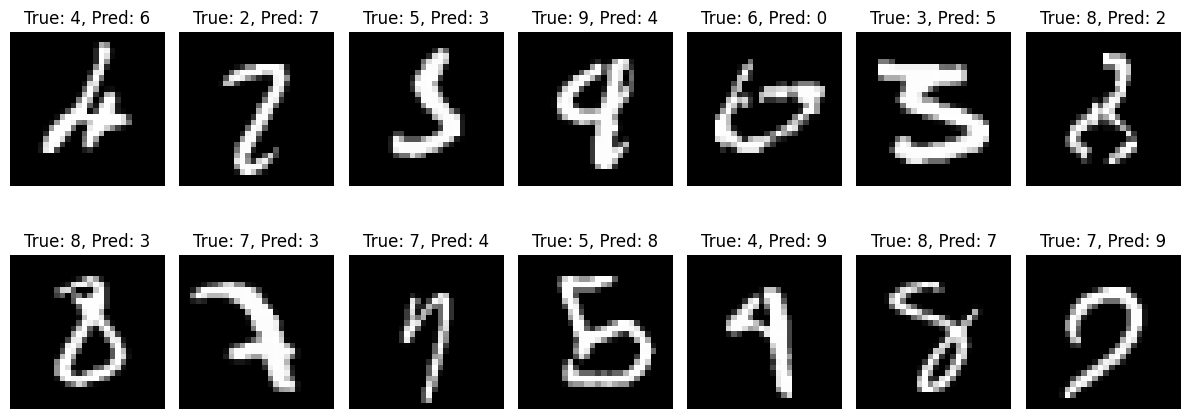

In [17]:
execute_this_cell = True
if not execute_this_cell:
    pass

else:
    incorrect_indices = np.where(np.array(all_predictions) != np.array(all_labels))[0]

    def visualize_incorrect_predictions(incorrect_indices, num_rows=2, num_cols=5):
        grid_width = 12
        grid_height = 5
        fig, axes = plt.subplots(num_rows, num_cols, figsize=(grid_width, grid_height))
        axes = axes.flatten()
        for i, ax in enumerate(axes):
            if i < len(incorrect_indices):
                idx = incorrect_indices[i]
                image, true_label, predicted_label = testset[idx][0], all_labels[idx], all_predictions[idx]
                ax.imshow(image.squeeze(), cmap='gray')
                ax.set_title(f'True: {true_label}, Pred: {predicted_label}')
                ax.axis('off')
        plt.tight_layout()
        plt.show()

    print(f'Number of incorrect predictions: {len(incorrect_indices)}')
    print(f"Here are some examples: ")

    #Assuming incorrect_indices, show the first 14 incorrect_indices
    visualize_incorrect_predictions(incorrect_indices[:14], num_rows=2, num_cols=7)

Check if accuracy has improved since last run

In [18]:
improvement = accuracy > accuracy_last_run

Saving the model for continuous training

In [19]:
if early_stopping_triggered == False:
    checkpoint = {
        'run': current_run,
        'num_of_epochs': num_epochs,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'accuracy': accuracy,
        'training_loss': avg_train_loss,
        'validation_loss': avg_val_loss,
        'best_validation_loss': best_val_loss,
        'run_duration': run_duration,
        'improvement': improvement
        }

    torch.save(checkpoint, checkpoint_path)


Saving data for statistics

In [20]:
def save_metrics_csv(current_run, num_epochs, precision, recall, f1, accuracy, avg_val_loss, best_val_loss, run_duration, improvement):
    # Check if the file exists to write headers only once
    file_exists = os.path.isfile(metrics_csv_path)

    with open(metrics_csv_path, 'a', newline='') as csvfile:
        fieldnames = ['Run', 'Epochs', 'Precision', 'Recall', 'F1 Score', 'Accuracy', 'Avg. Val. Loss', 'Best Val. Loss', 'Run Duration', 'Improvement']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

        if not file_exists:
            writer.writeheader()  # Write the header only if the file is new

        writer.writerow({
            'Run': current_run,
            'Epochs': num_epochs,
            'Precision': f'{precision:.2f}%',
            'Recall': f'{recall:.2f}%',
            'F1 Score': f'{f1:.2f}%',
            'Accuracy': f'{accuracy:.2f}%',
            'Avg. Val. Loss': f'{avg_val_loss}',
            'Best Val. Loss': f'{best_val_loss}',
            'Run Duration': f'{run_duration:.2f}s',
            'Improvement': improvement
        })

save_metrics_csv(current_run, num_epochs, precision, recall, f1, accuracy, avg_val_loss, best_val_loss, run_duration, improvement)


## Presenting statistics

In [21]:
def show_model():
    print(f"Optimizer: {optimizer_type}\n"
          f"Learning rate: {learning_rate}\n"
          f"Batch size: {batch_size}\n"
          f"Loss type: {loss_type}\n"
          f"Input channels: {input_channels}\n"
          f"Convolutional filters: {conv_filters}\n"
          f"Kernel size: {kernel_size}\n"
          f"(FC) Neurons: {fc_neurons}\n"
          f"Output classes: {output_classes}\n")

In [22]:

pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)
pd.set_option('display.width', 1000)
df = pd.read_csv(metrics_csv_path)

df['Accuracy'] = df['Accuracy'].str.rstrip('%').astype('float')
idx_best_accuracy = df['Accuracy'].idxmax()
best_run = df.iloc[[idx_best_accuracy]]
df['Accuracy'] = df['Accuracy'].apply(lambda x: f"{x}%")
show_model()
print(df)
print("\n[Run with the best accuracy]")
print(best_run)

Optimizer: Adam
Learning rate: 0.001
Batch size: 64
Loss type: CrossEntropyLoss()
Input channels: 1
Convolutional filters: 16
Kernel size: 3
(FC) Neurons: 64
Output classes: 10

    Run  Epochs Precision  Recall F1 Score Accuracy  Avg. Val. Loss  Best Val. Loss Run Duration  Improvement
0     1       1    95.93%  95.95%   95.93%   95.97%        0.207719        0.207719       23.18s         True
1     2       1    97.18%  97.17%   97.17%   97.18%        0.137978        0.137978       23.33s         True
2     3       1    97.39%  97.34%   97.35%   97.36%        0.112137        0.112137       27.60s         True
3     4       1    97.59%  97.61%   97.60%   97.61%        0.101941        0.101941       28.18s         True
4     5       1    97.83%  97.81%   97.81%   97.82%        0.082547        0.082547       27.88s         True
5     6       1    98.05%  98.05%   98.04%   98.05%        0.082437        0.082437       26.01s         True
6     7       1    98.02%  98.03%   98.02%   98.03% 

## Introducing custom digits to the model

In [23]:
from PIL import Image
from torch.utils.data import Dataset, DataLoader

# didgit_folder = 'my_own_digits/regular'
# didgit_folder = 'my_own_digits/with_padding'
# didgit_folder = 'my_own_digits/transparent'
didgit_folder = 'my_own_digits/white_background'

class CustomDigitDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(root_dir) if os.path.isfile(os.path.join(root_dir, f))]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.image_files[idx])
        image = Image.open(img_name)

        if self.transform:
            image = self.transform(image)

        return image

transform = transforms.Compose([
    transforms.Grayscale(),  # Convert to grayscale if the images are in RGB
    transforms.Resize((28, 28)),  # Resize images to the same size as the training data
    transforms.ToTensor(),  # Convert images to tensor
    transforms.Lambda(lambda x: 1.0 - x),
    transforms.Normalize((0.5,), (0.5,))  # Normalize images
])

#Initialize dataset
dataset = CustomDigitDataset(root_dir= didgit_folder, transform=transform)

# Create DataLoader
data_loader = DataLoader(dataset, batch_size=10, shuffle=False)


Predictions: [5, 1, 1, 1, 1, 5, 5, 7, 1, 7]


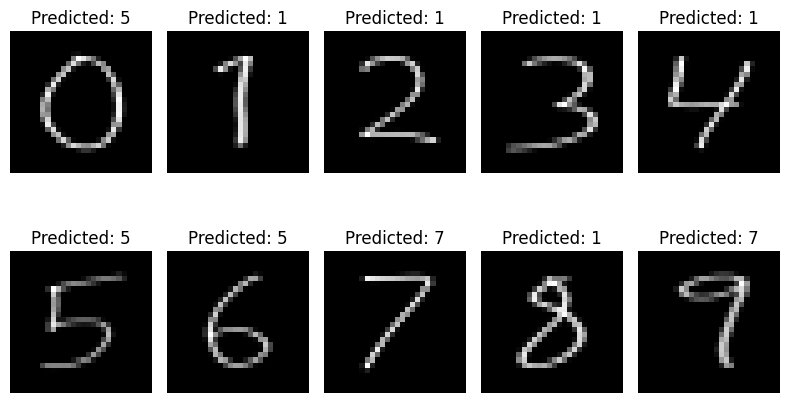

In [24]:
model.eval()

predictions = []

with torch.no_grad():
    for images in data_loader:
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.cpu().numpy())

# Function to visualize images and predictions
def visualize_predictions(images, predictions, num_rows=2, num_cols=5):
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(8, 5))
    axes = axes.flatten()

    for i, ax in enumerate(axes):
        if i < len(images):
            img = images[i].squeeze()  # Remove channel dimension if it's there
            ax.imshow(img, cmap='gray')
            ax.set_title(f'Predicted: {predictions[i]}')  # Show predicted label
            ax.axis('off')
        else:
            ax.axis('off')  # Hide axes if there are no more images to display
    print("Predictions:", predictions)
    plt.tight_layout()
    plt.show()

# Visualize the first batch of custom images with predictions
for images in data_loader:
    # Move images to CPU and convert to numpy for visualization
    images_np = images.numpy()

    # Visualize the images with predictions
    visualize_predictions(images_np, predictions[:len(images_np)], num_rows=2, num_cols=5)

    break  # We break here to only visualize one batch of images

In [25]:
# Calculate accuracy
correct_answers = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
correct_count = sum(pred == correct for pred, correct in zip(predictions, correct_answers))
accuracy = correct_count / len(correct_answers) * 100

# Save predictions with accuracy
with open(f'predictions/own_digits_predictions{model_specifics}.txt', 'a') as f:
    f.write(f"[Run: {current_run}] Predictions: {predictions}, Accuracy: {accuracy:.2f}%\n")

In [26]:
with open(f'predictions/own_digits_predictions{model_specifics}.txt', 'r') as f:
    for line in f:
        # Splitting the line to extract predictions and accuracy
        loaded_run = line.split(']')[0].split('[Run: ')[1]
        parts = line.strip().split('Predictions: ')
        predictions_part = parts[1].split(', Accuracy: ')[0]
        accuracy_part = parts[1].split(', Accuracy: ')[1]

        # Processing the predictions
        loaded_predictions = list(map(int, predictions_part.replace('[', '').replace(']', '').split(', ')))

        # Extracting the accuracy
        loaded_accuracy = float(accuracy_part.replace('%', ''))

        print(f"[Run: {loaded_run} | Number of epochs: {num_epochs} | Accuracy: {loaded_accuracy:.2f}%]")
        print(f"Correct answer: {correct_answers}")
        print(f"Predictions:    {loaded_predictions} \n")


[Run: 1 | Number of epochs: 1 | Accuracy: 40.00%]
Correct answer: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Predictions:    [0, 1, 2, 2, 1, 5, 5, 1, 3, 7] 

[Run: 2 | Number of epochs: 1 | Accuracy: 30.00%]
Correct answer: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Predictions:    [0, 1, 1, 1, 1, 5, 5, 1, 1, 7] 

[Run: 3 | Number of epochs: 1 | Accuracy: 40.00%]
Correct answer: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Predictions:    [0, 1, 2, 1, 1, 5, 5, 1, 3, 7] 

[Run: 4 | Number of epochs: 1 | Accuracy: 30.00%]
Correct answer: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Predictions:    [0, 1, 1, 1, 1, 5, 5, 1, 5, 7] 

[Run: 5 | Number of epochs: 1 | Accuracy: 40.00%]
Correct answer: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Predictions:    [1, 1, 2, 2, 1, 5, 5, 7, 1, 7] 

[Run: 6 | Number of epochs: 1 | Accuracy: 30.00%]
Correct answer: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Predictions:    [1, 1, 2, 2, 1, 5, 5, 1, 1, 7] 

[Run: 7 | Number of epochs: 1 | Accuracy: 30.00%]
Correct answer: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Predictions:    [1, 1, 2, 1

## Conclusion

The CNN performs very well on the MNIST dataset. The accuracy is for most of the time above 95%.

I've added my own 0-9 digits [image 1] and the results have been poor, not going over 40% accuracy once.

Consulting the web, I've found some possible answers to why that is and what sounded reasonable is that it can be quite picky when it comes to add your own images due to correct scaling, padding etc. 

I have tried to mimic the images from the MNIST dataset [image 2] as well as a could but, there might be more to it.

Since it never got over 40% accuracy even though I've tried it a lot of times, it points to that the model actually is learning but not reading the images right.
If it is just "guessing randomly" it would have (most likely) at some point got a higher accuracy score than 40%.
It also tends to predict some digits right and even though it is far from perfect there is still some consistency to the predictions [image 3]. 

1. Own digits <br>
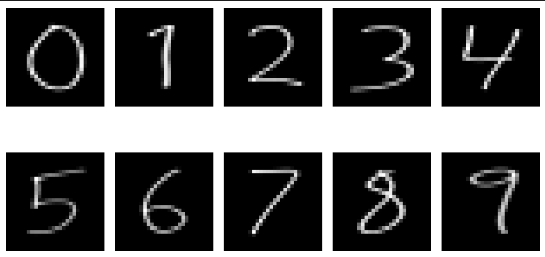 

2. MNIST dataset <br>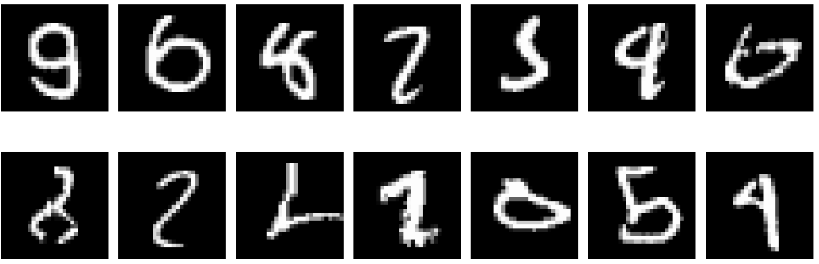

3. Predictions of own digits Target[0,1,2,3,4,5,6,7,8,9]<br>
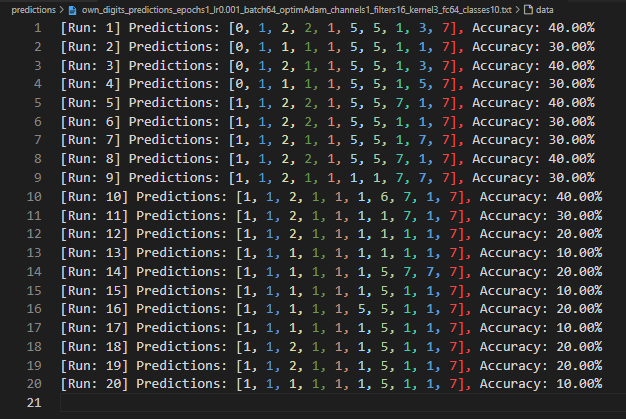